# Batch Inference Pipeline

This notebook demonstrates a batch inference pipeline for air quality prediction. The workflow includes:

1. **Data Preparation**: Loading and preparing historical air quality and weather data.
2. **Model Retrieval**: Fetching the pre-trained air quality prediction model from the model registry.
3. **Feature Engineering**: Creating features required for the model, including lagged PM2.5 values and weather parameters.
4. **Batch Prediction**: Using the model to predict future PM2.5 values based on the prepared features.
5. **Result Visualization**: Plotting the predicted PM2.5 values and saving the plots.
6. **Monitoring**: Inserting the predictions into a feature group for monitoring and evaluation.

The pipeline ensures that the predictions are continuously updated and monitored for accuracy.

In [42]:
from datetime import datetime, timedelta
import pandas as pd
import hopsworks
import json
import util

In [43]:
today = datetime.today().replace(hour=0, minute=0, second=0, microsecond=0)
yesterday = today - timedelta(days = 1)
today

datetime.datetime(2024, 11, 21, 0, 0)

In [44]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']
url=location['aqicn_url']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1157270
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [45]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=2,
)

Model registry

In [48]:
mr= project.get_model_registry()

retrieved_model=mr.get_model(
    name="air_quality_model",
    version=1,
)

saved_model_dir=retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [49]:
import joblib

retrieved_sklearn_model=joblib.load(saved_model_dir+"/model.pkl")

retrieved_sklearn_model

2024-11-21 01:25:48,841 WARNING: InconsistentVersionWarning: Trying to unpickle estimator DummyRegressor from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

2024-11-21 01:25:48,845 WARNING: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

2024-11-21 01:25:48,857 WARNING: InconsistentVersionWarning: Trying to unpickle estimator GradientBoostingRegressor from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://sc

GradientBoostingRegressor()

In [50]:
weather_fg= fs.get_feature_group(
    name='weather',
    version=2,
)

batch_data= weather_fg.filter(weather_fg.date >= today).read()
batch_data = batch_data.sort_values(by=['date']).reset_index(drop=True)

batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-21 00:00:00+00:00,-2.90,0.3,26.727423,297.255249,stockholm
1,2024-11-22 00:00:00+00:00,-5.35,0.0,15.124284,268.636108,stockholm
2,2024-11-23 00:00:00+00:00,-3.00,0.0,11.542478,273.576263,stockholm
3,2024-11-24 00:00:00+00:00,3.40,0.0,16.981165,158.875214,stockholm
4,2024-11-25 00:00:00+00:00,7.75,0.5,20.176065,195.524170,stockholm
5,2024-11-26 00:00:00+00:00,6.20,0.0,15.617529,205.974335,stockholm
6,2024-11-27 00:00:00+00:00,4.05,0.0,11.252519,7.352293,stockholm
7,2024-11-28 00:00:00+00:00,-0.15,0.0,9.957108,319.398773,stockholm
8,2024-11-29 00:00:00+00:00,0.45,0.0,5.634891,296.564972,stockholm


In [51]:
def get_pm25_value(row):
    """
    Returns the actual pm25 value if it exists (not NaN),
    otherwise returns the predicted_pm25 value.
    """
    return row['pm25'] if not pd.isna(row['pm25']) else row['predicted_pm25']


air_quality_fg= fs.get_feature_group(
    name='air_quality',
    version=2,
)


aq_batch_data= air_quality_fg.filter(air_quality_fg.date >= yesterday).read()       #Only need todays for future predictions. Makes it a dataframe
aq_batch_data = aq_batch_data.sort_values(by=['date']).reset_index(drop=True)

df_combined = pd.merge(
    aq_batch_data,
    batch_data,
    on='date',
    how='outer',  # Use 'outer' as we want all rows
)

for index in range(len(batch_data)):
    current_day=df_combined.loc[index,['date']]
  
    df_combined.at[index+1, 'pm25_1_days_before'] = get_pm25_value(df_combined.loc[index])
    df_combined.at[index+1,'pm25_2_days_before']=df_combined.loc[index,'pm25_1_days_before']
    df_combined.at[index+1,'pm25_3_days_before']=df_combined.loc[index,'pm25_2_days_before']

    
    current_features=df_combined.loc[index+1, ['pm25_1_days_before', 'pm25_2_days_before','pm25_3_days_before','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]

    current_features = pd.DataFrame(current_features.astype(float)).T       #Convert series to dataframe, and make sure the values are floats.
    next_pred=retrieved_sklearn_model.predict(current_features)
    df_combined.at[index+1,'predicted_pm25']=next_pred
    batch_data.at[index, 'predicted_pm25']=next_pred            #Has one less row, so starts earlier in index

batch_data.info()




Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.80s) 
2024-11-21 01:25:56,172 WARNING: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '21.971993963979873' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

2024-11-21 01:25:56,175 WARNING: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '21.971993963979873' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

2024-11-21 01:25:56,179 WARNING: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '21.971993963979873' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column                    

In [52]:
# Drop the first row, as it is today's date
batch_data.dropna(inplace=True)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-11-21 00:00:00+00:00,-2.90,0.3,26.727423,297.255249,stockholm,20.104222
1,2024-11-22 00:00:00+00:00,-5.35,0.0,15.124284,268.636108,stockholm,21.971994
2,2024-11-23 00:00:00+00:00,-3.00,0.0,11.542478,273.576263,stockholm,30.525461
3,2024-11-24 00:00:00+00:00,3.40,0.0,16.981165,158.875214,stockholm,34.136195
4,2024-11-25 00:00:00+00:00,7.75,0.5,20.176065,195.524170,stockholm,32.104268
5,2024-11-26 00:00:00+00:00,6.20,0.0,15.617529,205.974335,stockholm,33.753405
6,2024-11-27 00:00:00+00:00,4.05,0.0,11.252519,7.352293,stockholm,36.496208
7,2024-11-28 00:00:00+00:00,-0.15,0.0,9.957108,319.398773,stockholm,38.986199
8,2024-11-29 00:00:00+00:00,0.45,0.0,5.634891,296.564972,stockholm,46.388567


In [53]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data['predicted_pm25'] = batch_data['predicted_pm25'].astype("float32")
batch_data = batch_data.sort_values(by=['date'])

In [54]:
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-21 00:00:00+00:00,-2.90,0.3,26.727423,297.255249,stockholm,20.104223,stockholm-st-eriksgatan-83,sweden,1
1,2024-11-22 00:00:00+00:00,-5.35,0.0,15.124284,268.636108,stockholm,21.971994,stockholm-st-eriksgatan-83,sweden,2
2,2024-11-23 00:00:00+00:00,-3.00,0.0,11.542478,273.576263,stockholm,30.525461,stockholm-st-eriksgatan-83,sweden,3
3,2024-11-24 00:00:00+00:00,3.40,0.0,16.981165,158.875214,stockholm,34.136196,stockholm-st-eriksgatan-83,sweden,4
4,2024-11-25 00:00:00+00:00,7.75,0.5,20.176065,195.524170,stockholm,32.104267,stockholm-st-eriksgatan-83,sweden,5
5,2024-11-26 00:00:00+00:00,6.20,0.0,15.617529,205.974335,stockholm,33.753407,stockholm-st-eriksgatan-83,sweden,6
6,2024-11-27 00:00:00+00:00,4.05,0.0,11.252519,7.352293,stockholm,36.496208,stockholm-st-eriksgatan-83,sweden,7
7,2024-11-28 00:00:00+00:00,-0.15,0.0,9.957108,319.398773,stockholm,38.986198,stockholm-st-eriksgatan-83,sweden,8
8,2024-11-29 00:00:00+00:00,0.45,0.0,5.634891,296.564972,stockholm,46.388565,stockholm-st-eriksgatan-83,sweden,9


In [55]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
 7   street                       9 non-null      object             
 8   country                      9 non-null      object             
 9   days_before_forecast_day     9 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), objec

2024-11-21 01:25:56,832 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



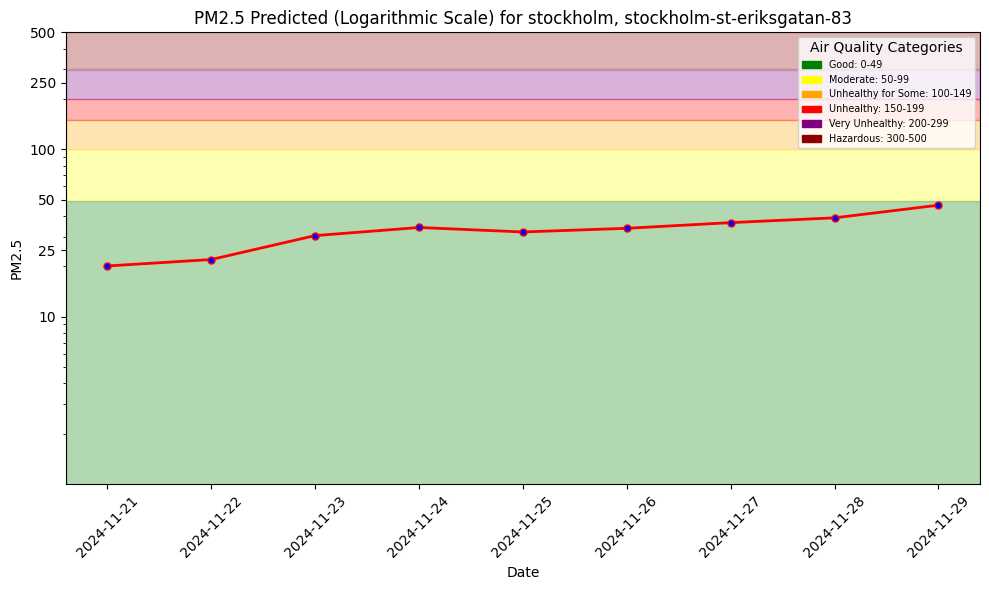

In [56]:
file_path = "docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [57]:
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=2,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [58]:
print(batch_data.head())
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

                       date  temperature_2m_mean  precipitation_sum  \
0 2024-11-21 00:00:00+00:00                -2.90                0.3   
1 2024-11-22 00:00:00+00:00                -5.35                0.0   
2 2024-11-23 00:00:00+00:00                -3.00                0.0   
3 2024-11-24 00:00:00+00:00                 3.40                0.0   
4 2024-11-25 00:00:00+00:00                 7.75                0.5   

   wind_speed_10m_max  wind_direction_10m_dominant       city  predicted_pm25  \
0           26.727423                   297.255249  stockholm       20.104223   
1           15.124284                   268.636108  stockholm       21.971994   
2           11.542478                   273.576263  stockholm       30.525461   
3           16.981165                   158.875214  stockholm       34.136196   
4           20.176065                   195.524170  stockholm       32.104267   

                       street country  days_before_forecast_day  
0  stockholm-st-erik

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1157270/jobs/named/aq_predictions_2_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1532a01d0>, None)

In [59]:
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-21 00:00:00+00:00,-2.9,0.3,26.727423,297.255249,stockholm,20.104223,stockholm-st-eriksgatan-83,sweden,1


In [60]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=2,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.44s) 


,date,pm25,country,city,street,url,pm25_1_days_before,pm25_2_days_before,pm25_3_days_before,pm25_avg_3_days_before
0,2021-06-27 00:00:00+00:00,24.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,27.0,37.0,26.0,30.000000
1,2023-12-15 00:00:00+00:00,24.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,19.0,21.0,25.0,21.666666
2,2024-09-22 00:00:00+00:00,10.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,19.0,23.0,24.0,22.000000
3,2021-11-09 00:00:00+00:00,20.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,14.0,9.0,13.0,12.000000
4,2021-04-24 00:00:00+00:00,9.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,12.0,17.0,26.0,18.333334
...,...,...,...,...,...,...,...,...,...,...
2138,2021-01-18 00:00:00+00:00,26.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,18.0,16.0,20.0,18.000000
2139,2024-11-19 00:00:00+00:00,27.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,20.0,14.0,13.0,15.666667
2140,2024-11-18 00:00:00+00:00,20.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,14.0,13.0,22.0,16.333334
2141,2024-11-20 00:00:00+00:00,21.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,27.0,20.0,14.0,20.333334


In [61]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_sklearn_model)
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-21 00:00:00+00:00,20.104223,19.0


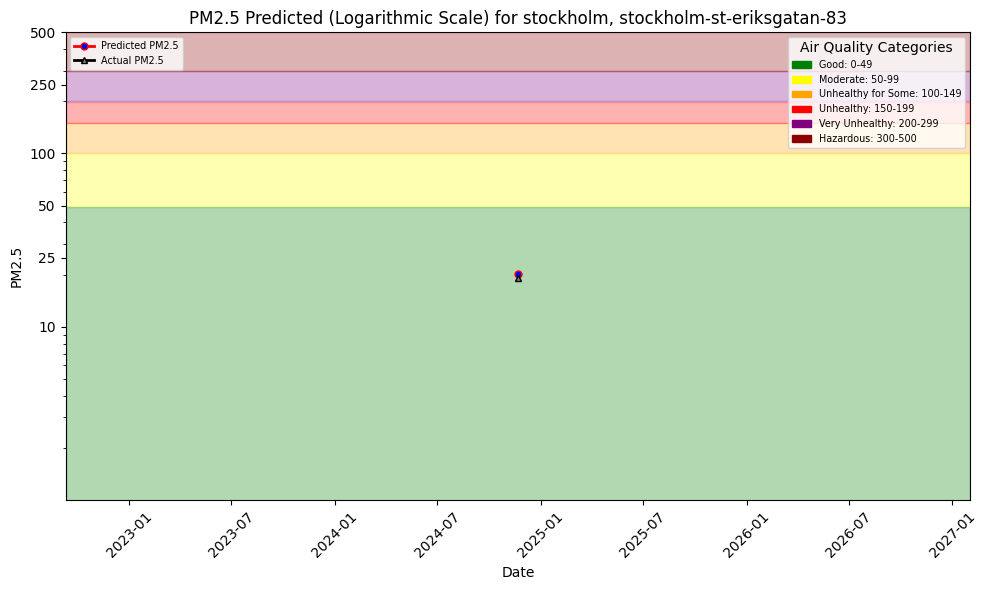

In [62]:
file_path = "docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()